# Importing the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

# 1. Loading the dataset

In [3]:
# Define the labels
labels = ['PNEUMONIA', 'NORMAL', 'TUBERCULOSIS', 'COVID19']

# Set the image size
img_size = 150

# Function to load the training, test, and validation data
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        i = 1
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                if(i%200 == 0):
                  print(i,class_num)
                i+=1
            except Exception as e:
                print(e)
    print("Data loaded")
    print()
    return np.array(data, dtype=object)

In [4]:
# Load the data

train = get_training_data('/content/drive/MyDrive/S6/Mini Project/Project v2 (PNCT)/v2 Dataset 5.1 (TB replaced with Belarus)/train')
test = get_training_data('/content/drive/MyDrive/S6/Mini Project/Project v2 (PNCT)/v2 Dataset 5.1 (TB replaced with Belarus)/test')
val = get_training_data('/content/drive/MyDrive/S6/Mini Project/Project v2 (PNCT)/v2 Dataset 5.1 (TB replaced with Belarus)/val')

200 0
400 0
600 0
800 0
1000 0
1200 0
1400 0
1600 0
1800 0
2000 0
2200 0
2400 0
2600 0
2800 0
3000 0
3200 0
3400 0
200 1
400 1
600 1
800 1
1000 1
1200 1
1400 1
1600 1
1800 1
2000 1
2200 1
2400 1
2600 1
2800 1
200 2
400 2
600 2
800 2
200 3
400 3
600 3
800 3
1000 3
Data loaded

200 0
400 0
200 1
Data loaded

200 0
400 0
200 1
Data loaded



# 2. Data Exploration

In [5]:
print(train[300])
train.shape

[array([[ 18,  32,  30, ..., 106, 110, 122],
        [ 18,  29,  28, ..., 107, 118, 121],
        [ 18,  30,  30, ..., 112, 114, 120],
        ...,
        [192, 184,  47, ...,  29,  35,  34],
        [191, 183,  48, ...,  29,  34,  34],
        [188, 172,  51, ...,  29,  34,  34]], dtype=uint8) 0]


(8063, 2)

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    elif(i[1] == 1):
        l.append("Normal")
    elif(i[1] == 2):
        l.append("Tuberculosis")
    elif(i[1] == 3):
        l.append("Covid19")
print(l)      

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia'

<Axes: ylabel='count'>

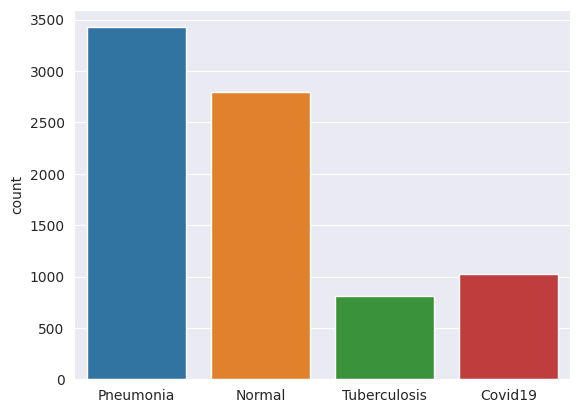

In [7]:
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'COVID19')

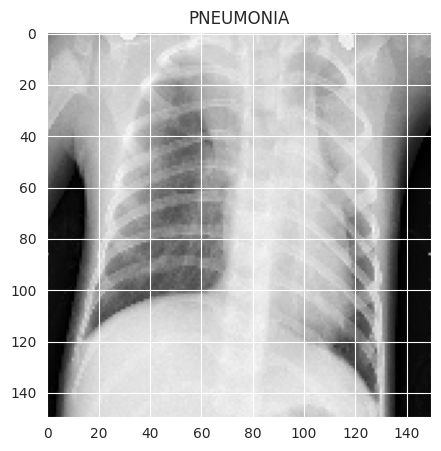

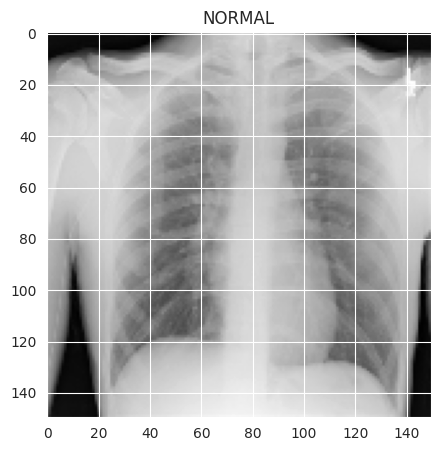

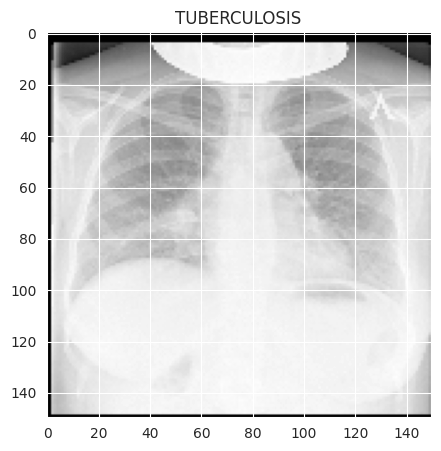

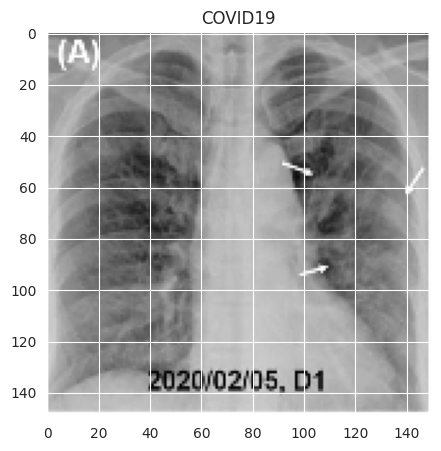

In [8]:
# Previewing an image from each class

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[3600][0], cmap='gray')
plt.title(labels[train[3600][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[6600][0], cmap='gray')
plt.title(labels[train[6500][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [9]:
# Split the data into features and labels

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [10]:
# Accessing the no. of elements of each class in train, test, and val respectively

from collections import Counter

def get_element_frequency(arr):
    frequency_counter = Counter(arr)
    return frequency_counter

for i in (y_train,y_test,y_val):
    frequency = get_element_frequency(i)
    for element, count in frequency.items():
        print(f"The element {element} appears {count} times.")
    print()

The element 0 appears 3425 times.
The element 1 appears 2800 times.
The element 2 appears 813 times.
The element 3 appears 1025 times.

The element 0 appears 427 times.
The element 1 appears 350 times.
The element 2 appears 100 times.
The element 3 appears 128 times.

The element 0 appears 427 times.
The element 1 appears 350 times.
The element 2 appears 99 times.
The element 3 appears 128 times.



In [11]:
num_test_samples = len(x_train)
print("Number of x_train samples:", num_test_samples)

num_test_samples = len(x_test)
print("Number of x_test samples:", num_test_samples)

num_test_samples = len(x_val)
print("Number of x_val samples:", num_test_samples)

Number of x_train samples: 8063
Number of x_test samples: 1005
Number of x_val samples: 1004


# 3. Data Preprocessing

**Normalization:** We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [12]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [13]:
# Resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [15]:
# Convert class vectors to binary class matrices (one-hot encoding)

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# 4. Model Training

In [16]:
# from tensorflow.keras.models import load_model

# model = load_model("/content/Model of Jv2 [95.52% acc] Dataset 5.1, 100 epoch, 16 batch size.h5")

In [17]:
# Building the model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Adjust the number of classes here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

In [18]:
len(model.layers)

20

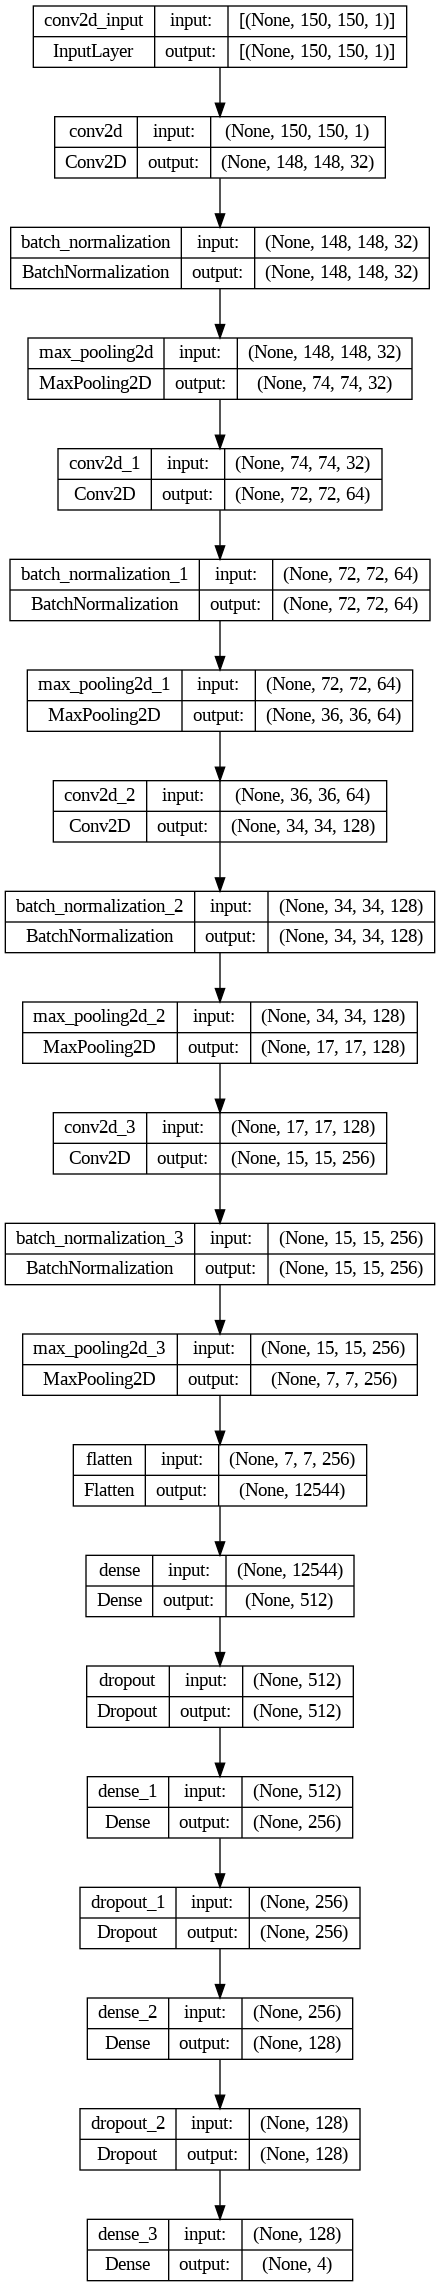

In [19]:
# Model Architecture Visualization

from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [21]:
# Training the model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/100
504/504 [==============================] - 24s 21ms/step - loss: 1.6381 - accuracy: 0.7392 - val_loss: 1.2514 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 2/100
504/504 [==============================] - 10s 20ms/step - loss: 0.4459 - accuracy: 0.8568 - val_loss: 0.2896 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 3/100
504/504 [==============================] - 10s 19ms/step - loss: 0.3530 - accuracy: 0.8804 - val_loss: 0.4122 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 4/100
503/504 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8975
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
504/504 [==============================] - 10s 19ms/step - loss: 0.3016 - accuracy: 0.8976 - val_loss: 0.3262 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 5/100
504/504 [==============================] - 9s 19ms/step - loss: 0.2058 - accuracy: 0.9349 - val_loss: 2.6077 - val_accuracy: 0.6783 - lr: 3.0000e-04
Epoch 6/100
502/504 [=========================

In [22]:
print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, "%")

32/32 [==============================] - 1s 17ms/step - loss: 0.1765 - accuracy: 0.9512
Loss of the model is -  0.17653706669807434
32/32 [==============================] - 0s 10ms/step - loss: 0.1765 - accuracy: 0.9512
Accuracy of the model is -  95.12437582015991 %


In [23]:
model.save("Model of Jv2 [95.52% acc] Dataset 5.1, 100 epoch, 16 batch size.h5")

# 5. Post-Training Analysis:

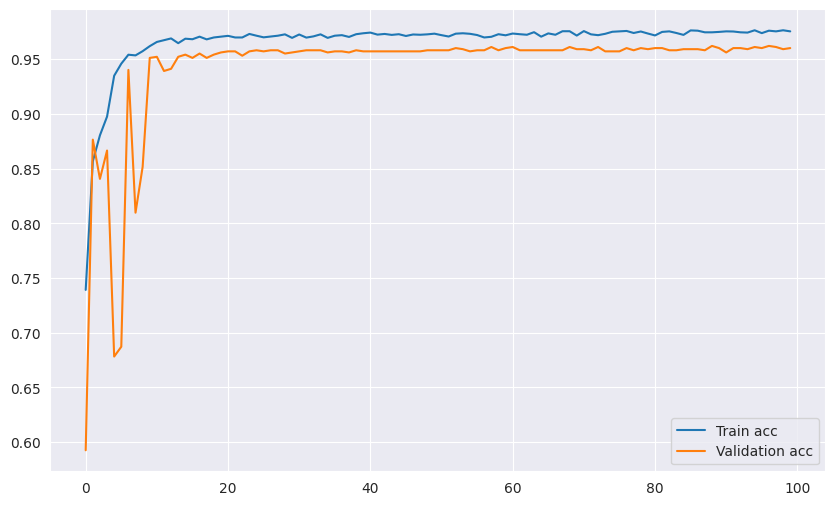

In [24]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

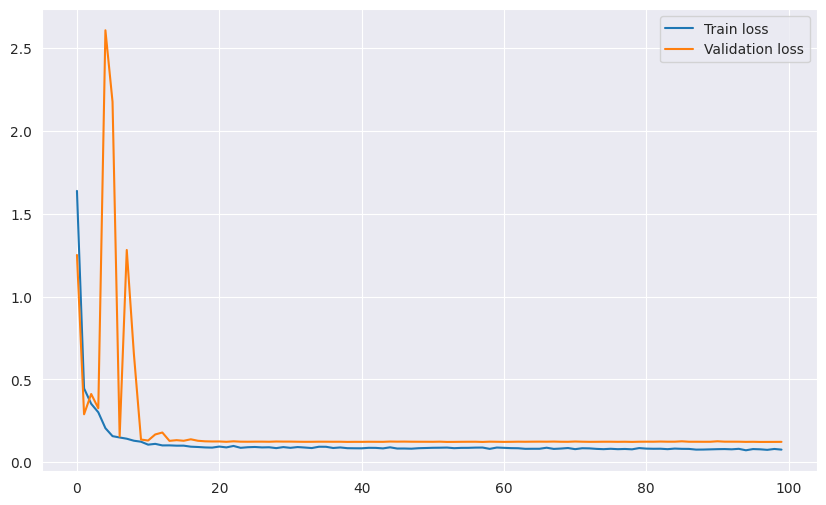

In [25]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

# 6. Precision, Recall, F1-score, Support

In [26]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels
true_labels = np.argmax(y_test, axis=1)  # Convert true labels to class labels

32/32 [==============================] - 0s 8ms/step


In [27]:
print(classification_report(true_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.99      1.00      0.99       427
      NORMAL       0.92      0.97      0.94       350
TUBERCULOSIS       0.96      0.98      0.97       100
     COVID19       0.91      0.73      0.81       128

    accuracy                           0.95      1005
   macro avg       0.94      0.92      0.93      1005
weighted avg       0.95      0.95      0.95      1005



# 7. Confusion Matrix

In [28]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[425,   0,   0,   2],
       [  0, 340,   3,   7],
       [  0,   2,  98,   0],
       [  5,  29,   1,  93]])

In [29]:
cm = pd.DataFrame(cm, index=labels, columns=labels)

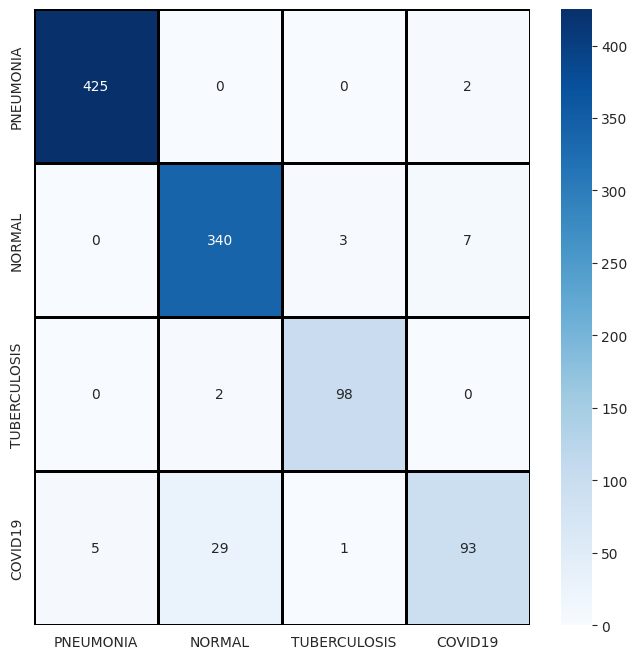

In [30]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.show()

# 8. ROC Curve

32/32 [==============================] - 0s 8ms/step


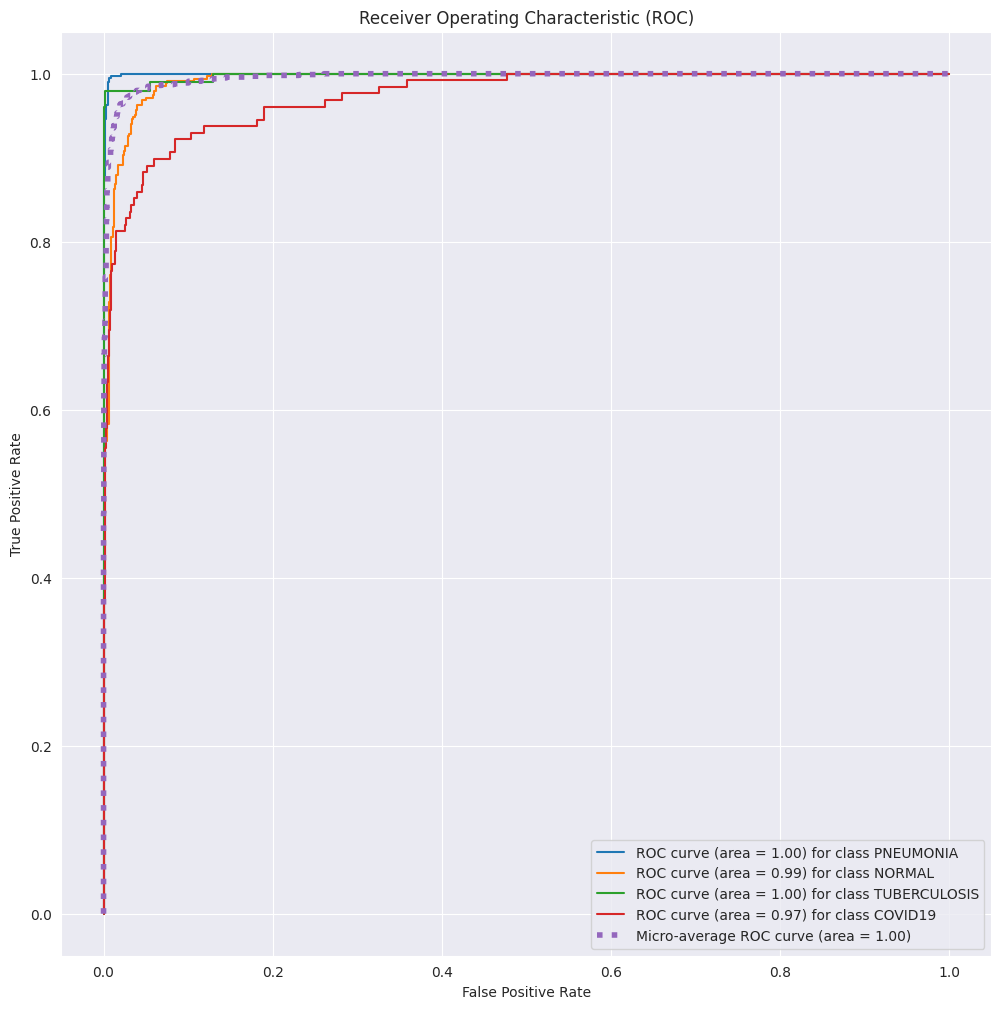

In [31]:
y_pred = model.predict(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 4

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,12))

# Plot ROC curves for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], labels[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"], linestyle=':', linewidth=4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 9. Visualizing the predicted images

In [32]:
correct = np.nonzero(predicted_labels == true_labels)[0]
incorrect = np.nonzero(predicted_labels != true_labels)[0]

In [33]:
correct

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

In [34]:
correct.size

956

In [35]:
incorrect

array([  81,  204,  475,  491,  551,  597,  609,  618,  695,  706,  758,
        772,  829,  870,  882,  883,  884,  885,  886,  888,  897,  898,
        901,  903,  907,  911,  914,  918,  921,  926,  939,  940,  941,
        942,  955,  964,  968,  969,  970,  974,  976,  978,  979,  993,
        994,  996,  997,  999, 1004])

In [36]:
incorrect.size

49

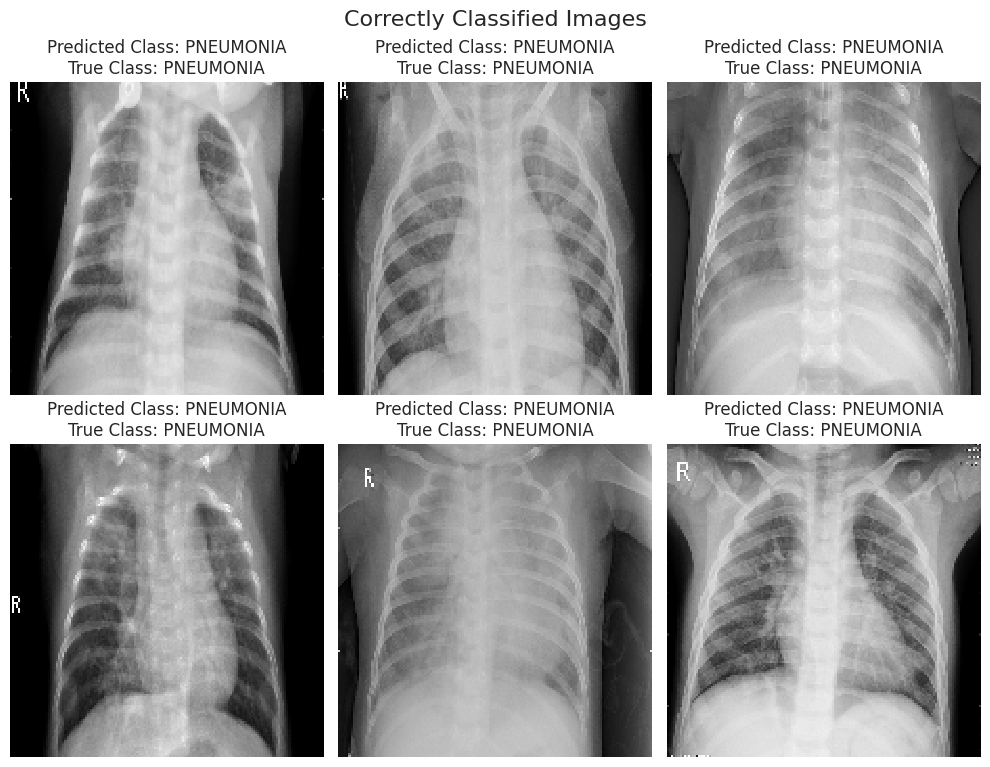

In [37]:
# Visualize correctly classified images

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Correctly Classified Images', fontsize=16)
for i, idx in enumerate(correct[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nTrue Class: {}".format(labels[predicted_labels[idx]], labels[true_labels[idx]]))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

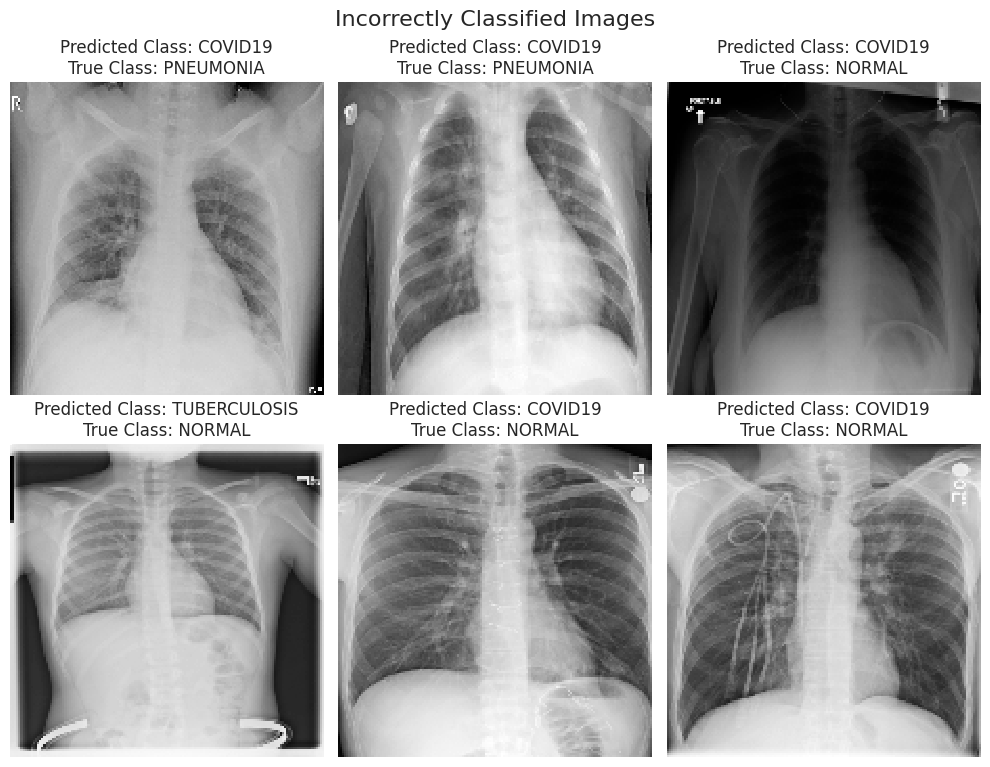

In [38]:
# Visualize incorrectly classified images

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Incorrectly Classified Images', fontsize=16)
for i, idx in enumerate(incorrect[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nTrue Class: {}".format(labels[predicted_labels[idx]], labels[true_labels[idx]]))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# 10. Random Predictions

In [39]:
image = '/content/drive/MyDrive/S6/Mini Project/Project v2 (PNCT)/v2 Dataset 5.1 (TB replaced with Belarus)/test/TUBERCULOSIS/1.3.6.1.4.1.25403.163683357445804.11044.20131119114302.50.png'
def preprocess_image(image_path):
    img_arr = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_arr = cv2.resize(img_arr, (img_size, img_size))
    preprocessed_img = np.array(resized_arr) / 255.0
    preprocessed_img = preprocessed_img.reshape(-1, img_size, img_size, 1)
    return preprocessed_img

# Assuming 'image' is the variable containing the path to the image you want to predict
preprocessed_img = preprocess_image(image)
prediction = model.predict(preprocessed_img)
predicted_class = labels[np.argmax(prediction)]
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 163ms/step
Predicted class: TUBERCULOSIS
